<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

In [3]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [4]:
mean = 0.13066048920154572
std = 0.30810779333114624

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])])

train_data = datasets.MNIST(root = '.data',
                            train = True,
                            download = True,
                            transform = train_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 470kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.51MB/s]


In [5]:
batch_size = 128
train_dataloader = data.DataLoader(train_data,
                                   shuffle=True,
                                   batch_size =  batch_size)

In [6]:
img,label = next(iter(train_dataloader))

In [7]:
img[0].shape

torch.Size([1, 28, 28])

In [8]:
label[0]

tensor(6)

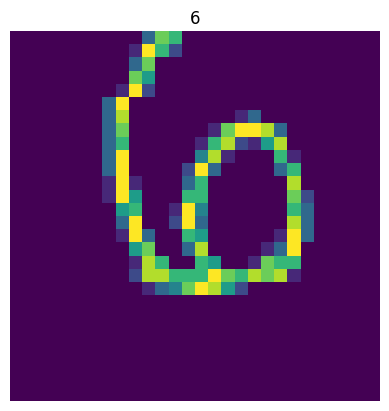

In [9]:
plt.imshow(img[0].permute(1,2,0).squeeze(0))
plt.title(label[0].item())
plt.axis('off')
plt.show()

In [10]:
class MLP(nn.Module):
  def __init__(self,input_dim,output_dim,hidden_dim):
    super().__init__()
    self.l1 = nn.Linear(input_dim,hidden_dim)
    self.l2 = nn.Linear(hidden_dim,hidden_dim)
    self.l3 = nn.Linear(hidden_dim,output_dim)
    self.init_params()

  def init_params(self):
    for n,p in self.named_parameters():
      if 'weight' in n:
        nn.init.kaiming_normal_(p,nonlinearity='relu')
      elif 'bias' in n:
        nn.init.constant_(p,0)

  def forward(self,x):
    batch_size,*_ = x.shape
    x = x.view(batch_size,-1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = self.l3(x)
    return x


In [11]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, output_dim, hid_dim)

In [12]:
model

MLP(
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)
device

device(type='cuda')

In [43]:
def train(train_dataloader,optimizer,model,device,criterion,epoches):
  losses = []

  model.init_params()
  for epoch in range(epoches):
    epoch_loss = []
    for img,label in tqdm.tqdm(train_dataloader):
      img,label = img.to(device),label.to(device)
      preds = model(img)
      loss = criterion(preds,label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss.append(loss.item())
    losses.extend(epoch_loss)
  return  losses




In [16]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

In [18]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

In [26]:
class sgd:
  def __init__(self,model_params,lr=1e-3):
    self.model_params = list(model_params)
    self.lr = lr

  def zero_grad(self):
    for param in self.model_params:
      param.grad = None

  @torch.no_grad()
  def step(self):
    for param in self.model_params:
      param.sub_(self.lr*param.grad)

In [27]:
optimizer = sgd(model.parameters())

In [28]:
optimizer

In [39]:
sgd_loss = train(train_dataloader,optimizer,model,device,criterion,5)

100%|██████████| 469/469 [00:22<00:00, 20.73it/s]


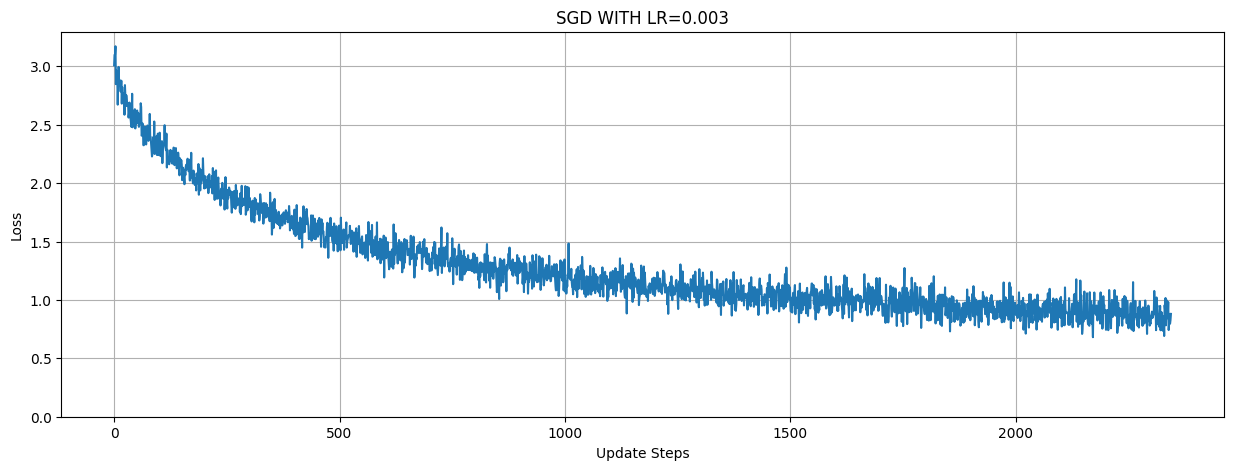

In [41]:
plot_loss(sgd_loss,'SGD WITH LR=0.003')